# Rat RNN
Things to try:
- Separate W_in and W_rec for different initialization (per paper)
- Initialize W_out as orthogonal (per paper)
- Hessian-free optimization (Martens 2010)
- Implement adaptive weighting on:
    - R_L2 according to Martens & Sutskever (2011)
    - R_FR according to paper (but not totally clear?)

### Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

/home/james/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters

In [2]:
exp_descr = 'corrected weight initializations (and tau)'
env_name = 'rat_square' # Name of the Unity environment binary to launch

learning_rate = 1e-4
weights_regularization = 0.2
act_regularization = 0.2
hidden_units = 128
train_steps = 10000
ep_length = 500
sim_steps = 1000000
batch_size = 512

tau = 1.0
noise_stddev = 0.5
zero_speed_probability = 0.5

# [rotation.y, velocity.x, velocity.z, angularVelocity.y, velocity.magnitude, heading, velocity]
x_components = [0, 4]

unity_params = {
    'start_area_extents': 8.0,
    'ep_length': ep_length}

exp_path = 'data/' + env_name + '/trial_5/'
model_path = exp_path + 'model'
data_path = 'data/rat_square/trial_4/' + 'data'

if not os.path.exists(exp_path):
    os.makedirs(exp_path)
else:
    print("Warning: Data may already exist in specified filepath. Are you sure you want to continue?")

In [3]:
f = open(exp_path + "settings.txt", "w+")
_ = f.write("description: " + exp_descr + "\n")
_ = f.write("env_name: " + env_name + "\n")
_ = f.write("learning_rate: " + str(learning_rate) + "\n")
_ = f.write("weights_regularization: " + str(weights_regularization) + "\n")
_ = f.write("hidden_units: " + str(hidden_units) + "\n")
_ = f.write("train_steps: " + str(train_steps) + "\n")
_ = f.write("ep_length: " + str(ep_length) + "\n")
_ = f.write("sim_steps: " + str(sim_steps) + "\n")
_ = f.write("batch_size: " + str(batch_size) + "\n")
_ = f.write("tau: " + str(tau) + "\n")
_ = f.write("noise_stddev: " + str(noise_stddev) + "\n")
_ = f.write("zero_speed_probability: " + str(zero_speed_probability) + "\n")
_ = f.write("x_components: " + str([x for x in x_components]) + "\n")
_ = f.write("unity_params: " + str([[k, v] for k, v in unity_params.items()]) + "\n")
_ = f.write("model_path: " + model_path + "\n")
_ = f.write("data_path: " + data_path + "\n")
#files_to_copy = [agent_file_path, net_file_path, config_file_path]
#for fp in files_to_copy:
#    new_fp = folder + fp.split("/")[-1]
#    while os.path.exists(new_fp):
#        t = new_fp.split(".")
#        new_fp = '.'.join(['.'.join(t[0:-1]) + '_1', t[-1]])
#    copy(fp, new_fp)

## Generate Data
Prerequisite: Load unity project in the Editor. Build and save executable as "rat.exe" or "rat.app".

### Start Environment
Two things to note:
- `Windowed` option must be selected in settings window.
- Current working directory must contain folder `<env_name>_Data` (case-sensitive); otherwise, environment will fail to respond.

In [4]:
env = UnityEnvironment(file_name=env_name, worker_id=1)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		ep_length -> 500.0
		start_area_extents -> 0.0
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 10
        Action space type: continuous
        Action space size (per agent): 1
        Memory space size (per agent): 0
        Action descriptions: 


### Collect States

In [5]:
x,z,ep = [], [], []
input_x = []
a = env.reset(config=unity_params)[default_brain]
for i in range(sim_steps - 1):
    
    # check for NANs
    if a.states[0].dtype != np.float64:
        print(i, a.states[0].dtype, a.states[0])
    elif np.any(np.isnan(a.states[0])):
        print(i, "NAN", a.states[0])
        
    # append
    x.append(a.states[0][0])
    z.append(a.states[0][1])
    input_x.append(a.states[0][2:-1])
    ep.append(a.states[0][-1])

    # next simulation step
    a = env.step(action=0)[default_brain]

    if i % (sim_steps/10) == 0 and i != 0:
        print(i)

INFO:unityagents.environment:
Academy Reset. In Lesson 0 : 	start_area_extents -> 8.0, ep_length -> 500


100000
200000
300000
400000
500000
600000
700000
800000
900000


In [6]:
x = np.array(x)
z = np.array(z)
input_x = np.array(input_x)
input_y = np.stack((x, z), axis=1)

### Save Training Data

In [7]:
if not os.path.exists(data_path):
    os.makedirs(data_path)

save_data = {"x": input_x, "y": input_y}
pickle.dump(save_data, open(data_path+"/data.p", "wb"))

## Load Training Data

In [4]:
save_data = pickle.load(open(data_path+"/data.p", "rb"))
input_x = save_data["x"]
input_y = save_data["y"]
x = input_y[:, 0]
z = input_y[:, 1]

### Set input as (angle, speed) and normalize values

In [5]:
# [rotation.y, velocity.x, velocity.z, angularVelocity.y, velocity.magnitude, heading, velocity]
print(np.shape(input_x))
input_x = input_x[:, x_components] # rotation and velocity
input_x[:,-1] /= np.max(abs(input_x[:,-1]))
print(np.shape(input_x))

(999999, 7)
(999999, 2)


In [6]:
print(np.min(input_x[:,0]), np.max(input_x[:,0]))
print(np.min(input_x[:,1]), np.max(input_x[:,1]))

-1.00003159 0.999967456
0.0 1.0


### Normalize maze positions

In [7]:
print(np.max(np.abs(input_y[:, 0])), np.max(np.abs(input_y[:, 1])))
input_y[:, 0] /= np.max(np.abs(input_y[:, 0]))
input_y[:, 1] /= np.max(np.abs(input_y[:, 1]))
x = input_y[:, 0]
z = input_y[:, 1]

maze_extents = np.max(np.abs(input_y[:, :]))
maze_extents *= 1.125 # plus 12% for borders

print(maze_extents)

9.03635 9.033402
1.125


### Visualize Rat Trajectory

In [8]:
def create_colors(length, segments):
    c_list = []
    for i in range(segments):
        color = np.zeros([length//segments, 4])
        color[:, 3] = 0.5
        color[:, 0:3] = np.random.uniform(0, 1, size=[1, 3])
        c_list.append(color)
    c_list = np.reshape(c_list, [length, 4])
    return c_list

(-1.125, 1.125)

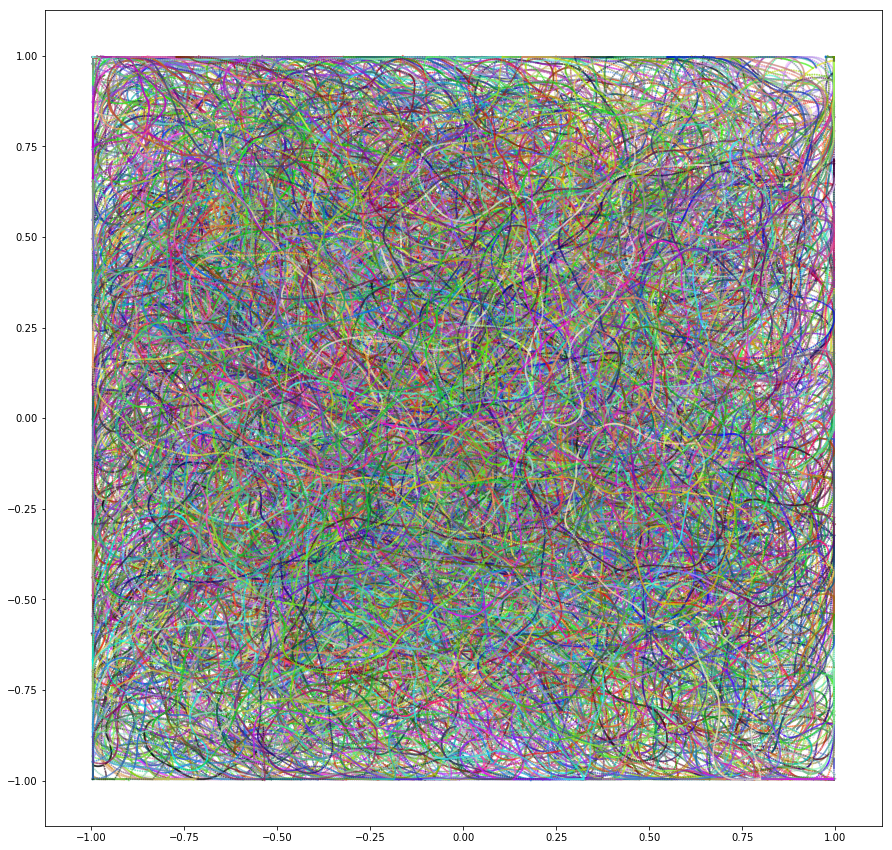

In [9]:
plt.figure(figsize=(15, 15))
plt.scatter(x, z, s=1, c=create_colors(sim_steps, sim_steps//ep_length))
plt.ylim(-maze_extents, maze_extents)
plt.xlim(-maze_extents, maze_extents)

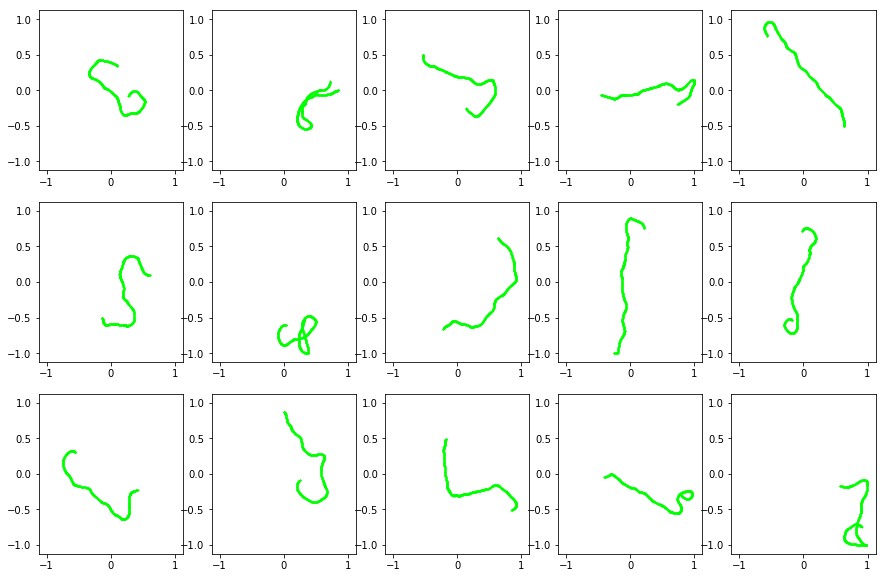

In [10]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-maze_extents, maze_extents)
    plt.xlim(-maze_extents, maze_extents)
plt.show()

## Rat RNN

### Define Network

In [11]:
import numpy as np
from scipy.linalg import qr

class orthogonal_initializer(tf.contrib.keras.initializers.Initializer):
    def __init__(self, dtype=tf.float32):
        self.dtype = dtype

    def __call__(self, shape, dtype=None, partition_info=None):
        if dtype is None:
            dtype = self.dtype
        
        # If m ≤ n, then the columns of Q will form an orthonormal basis of R^m
        # If m > n, then the columns of Q will form a linearly independent subspace of R^n
        H = np.random.randn(*shape) # m x n
        Q, R = qr(H) # m x m, m x n
        Q = Q[:, :shape[1]] # m x min(m, n)
        
        return tf.constant(Q, dtype=dtype, shape=shape)

In [12]:
class MyBasicLSTMCell(tf.contrib.rnn.RNNCell):
  def __init__(self, num_units, noise_stddev, forget_bias=1.0,
               activation=None, reuse=None):
    super(MyBasicLSTMCell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self._noise_stddev = noise_stddev
    self._forget_bias = forget_bias
    self._activation = activation or tf.nn.tanh
    self._linear = None

  @property
  def state_size(self):
    return (tf.contrib.rnn.LSTMStateTuple(self._num_units, self._num_units))

  @property
  def output_size(self):
    return self._num_units

  def call(self, inputs, state):
    sigmoid = tf.sigmoid
    c, h = state

    if self._linear is None:
        self._linear = _Linear([inputs, h], 4 * self._num_units, True)
    # i = input_gate, j = new_input, f = forget_gate, o = output_gate
    i, j, f, o = tf.split(
        value=self._linear([inputs, h]), num_or_size_splits=4, axis=1)

    new_c = (
        c * sigmoid(f + self._forget_bias) + sigmoid(i) * self._activation(j))
    new_h = self._activation(new_c) * sigmoid(o)
    new_h = tf.add(new_h,
                   tf.random_normal(shape=tf.shape(new_h), mean=0.0, stddev=self._noise_stddev, dtype=tf.float32))

    new_state = tf.contrib.rnn.LSTMStateTuple(new_c, new_h)
    return new_h, new_state


#from tensorflow.python.ops.rnn_cell_impl import _Linear
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear

# For API conventions, see 
# https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/python/ops/rnn_cell_impl.py
# (note tf version!)
#
# I think he copied the code initially from here, since it is the only place with two-space
# indentation. Anyways, for any subclass of tf.contrib.rnn.RNNCell, required properties are 
# state_size and output_size, and required method is call, which maps 
# (inputs, state) to (outputs, new_state).
#
# _Linear essentially maps a list of args of shape [batch_size, hidden_size_i] to 
# an output tensor of shape [batch_size, output_size] by simple linear transformation with
# weight matrices [hidden_size_i, output_size] and adding a bias if specified. This 
# essentially allows for easy concatentation of input and hidden state. It uses 
# tf.get_variable to both create the variable during first call and look up the variable 
# during subsequent calls. See lines 970-1032 of the link above.
#
# In commit (https://github.com/tensorflow/tensorflow/commit/37fbebdd6c3c8f274896cc36e6feb5b7e2097a59)
# in v 1.5, rnn ops were moved to contrib: tf.contrib.rnn.python.ops.core_rnn_cell
# and _linear became a class _Linear that uses the definition _linear in its __init__
# and later __call__ functions.

class MyCTRNNCell(tf.contrib.rnn.RNNCell):
  def __init__(self, num_units, tau, noise_stddev, activation=None, reuse=None):
    super(MyCTRNNCell, self).__init__(_reuse=reuse)
    self._num_units = num_units
    self._tau = tau
    self._noise_stddev = noise_stddev
    self._activation = activation or tf.nn.tanh
    self._linear = None

  @property
  def state_size(self):
    return (tf.contrib.rnn.LSTMStateTuple(self._num_units, self._num_units))

  @property
  def output_size(self):
    return self._num_units

  def call(self, inputs, state):
    """ Continuous Time RNN:
        dx/dt = -x + W * input + U * act(x) + B + noise
        x' = x + 1/tau * dx/dt
    """
    # u_t = act(x_t)
    old_x, old_u = state
    new_u = self._activation(old_x)
    
    # Allows _linear to be set initially without having to provide input and output sizes
    # in constructor (__init__)
    if self._linear is None:
        # Get input shape
        N_in = inputs.get_shape().as_list()[1]

        # W_in <-- N(0, (1/N_in)**0.5)
        # Note: N_in must be cast to float for math operation, but using tf.cast throws
        # an error by pointing back to a tensor in the rnn while loop during the initial
        # construction call
        W_in_init = tf.random_normal_initializer(mean=0.0, 
                                                 stddev=(1.0/float(N_in))**0.5,
                                                 dtype=tf.float32)
        W_in = tf.get_variable("W_in",
                               shape=[N_in, self._num_units],
                               initializer=W_in_init)
        
        # W_rec <-- orthogonal
        W_rec = tf.get_variable("W_rec",
                                shape=[self._num_units, self._num_units],
                                initializer=orthogonal_initializer())
        
        # Set linear transformation function
        self._weights = tf.concat([W_in, W_rec], axis=0, name="weights")
        self._bias = tf.get_variable("bias",
                                     shape=[1, self._num_units],
                                     initializer=tf.zeros_initializer())
        self._linear = lambda args: (tf.matmul(tf.concat(args, axis=1), self._weights)
                                     + self._bias)
        #self._linear = _Linear(args=[inputs, new_u], 
        #                       output_size=self._num_units, 
        #                       build_bias=True,
        #                       bias_initializer=tf.zeros_initializer,
        #                       kernel_initializer=tf.ones_initializer)

    # dx/dt = -x_t + W_Ix * input + W_xx * u_t + b + noise
    dxdt = self._linear([inputs, new_u]) # W_Ix * input + W_ux * u_t + b
    dxdt -= old_x # -x_t
    noise = tf.random_normal(shape=tf.shape(dxdt), 
                             mean=0.0, 
                             stddev=self._noise_stddev, 
                             dtype=tf.float32)
    dxdt = tf.add(dxdt, noise) # + noise
    
    # Euler update: x_(t+1) = x_t + delta * dx/dt
    #new_x = old_x + 1.0/self._tau * dxdt
    new_x = old_x + self._tau/10.0 * dxdt
    
    # Return u_t (not x_t) since u_t (not x_t) is used to update the cell 
    # at the next time step
    return new_u, tf.contrib.rnn.LSTMStateTuple(new_x, new_u)

In [13]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, batch_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        #self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)
        self.noise_stddev = tf.placeholder(shape=[1], dtype=tf.float32)

        self.rnn_in = tf.reshape(self.x, shape=[batch_size, self.train_length[0], x_size])

        self.cell = MyCTRNNCell(h_size, tau, self.noise_stddev)
        self.state_in = self.cell.zero_state(batch_size, tf.float32)
        
        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, 
                                                     cell=self.cell, 
                                                     dtype=tf.float32,
                                                     initial_state=self.state_in)
        
        self.output = tf.reshape(self.rnn, shape=[-1, h_size])  
        
        self.y_pred = tf.layers.dense(self.output, y_size,
                                      kernel_initializer=tf.zeros_initializer(),
                                      use_bias=False,
                                      activation=None,
                                      name="y_pred")

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)
        
        # tf.nn.l2_loss computes half sum of squares, so divide by 0.5 for correct normalization
        lossL2A = tf.nn.l2_loss(self.output) / float(batch_size * h_size * ep_length * 0.5)
        lossL2W = tf.add_n([ tf.nn.l2_loss(v) / (0.5 * N_i) for v, N_i in zip(tf.trainable_variables(), [float(x_size), float(y_size)]) 
                             if 'bias' not in v.name ]) / float(h_size)

        self.weights_loss = lossL2W * weights_regularization
        self.act_loss = lossL2A * act_regularization
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred)) / float(batch_size * ep_length * y_size)
        self.loss = self.regress_loss + self.weights_loss + self.act_loss

        #self.loss = tf.Print(self.loss, [lossL2A, lossL2W, self.regress_loss])

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [14]:
tf.reset_default_graph()
rat_rnn = RatRNN(len(x_components), 2, hidden_units, batch_size, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()
graph = tf.get_default_graph()

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

print(tf.trainable_variables())

[<tf.Variable 'rnn/my_ctrnn_cell/W_in:0' shape=(2, 128) dtype=float32_ref>, <tf.Variable 'rnn/my_ctrnn_cell/W_rec:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'rnn/my_ctrnn_cell/bias:0' shape=(1, 128) dtype=float32_ref>, <tf.Variable 'y_pred/kernel:0' shape=(128, 2) dtype=float32_ref>]


In [15]:
# Verify W_rec is orthogonal
W_rec = sess.run(graph.get_tensor_by_name("rnn/my_ctrnn_cell/W_rec:0"))
s = 1.0
for i in range(W_rec.shape[1]):
    s *= W_rec[:, i]
print(np.sum(s))
print(np.count_nonzero(W_rec))

# Verify W_in is from correct distribution
W_in = sess.run(graph.get_tensor_by_name("rnn/my_ctrnn_cell/W_in:0"))
print(np.mean(W_in), np.std(W_in))
print(0.0, (1.0/len(x_components))**0.5)

0.0
16384
-0.023468975 0.72300327
0.0 0.7071067811865476


### Train Network

In [16]:
print(tf.test.is_gpu_available())

True


500 2000.0


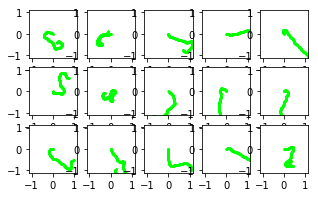

In [17]:
losses = []
print(ep_length, sim_steps/ep_length)

# center training data
input_Y = np.copy(input_y)
for i in range(sim_steps//ep_length):
    pointer = i
    input_Y[pointer*ep_length:(pointer+1)*ep_length] -= input_Y[pointer*ep_length]

# debug viz
plt.figure(figsize=(5,3))
for i in range(15):
    pointer = i
    batch_y = input_Y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-maze_extents, maze_extents)
    plt.xlim(-maze_extents, maze_extents)
plt.show()

Loss: 0.4246942400932312 -- 1
Loss: 0.3730274736881256 -- 2
Loss: 0.29570502042770386 -- 3
Loss: 0.26767465472221375 -- 4
Loss: 0.25821882486343384 -- 5
Loss: 0.2504138648509979 -- 6
Loss: 0.24490316212177277 -- 7
Loss: 0.24088752269744873 -- 8
Loss: 0.236277237534523 -- 9
Loss: 0.23370090126991272 -- 10
Loss: 0.22813934087753296 -- 11
Loss: 0.22626562416553497 -- 12
Loss: 0.2237558364868164 -- 13
Loss: 0.2184988111257553 -- 14
Loss: 0.21376901865005493 -- 15
Loss: 0.21113869547843933 -- 16
Loss: 0.2091692090034485 -- 17
Loss: 0.20712248980998993 -- 18
Loss: 0.20326931774616241 -- 19
Loss: 0.2017158418893814 -- 20
Loss: 0.19902603328227997 -- 21
Loss: 0.1955377608537674 -- 22
Loss: 0.19413207471370697 -- 23
Loss: 0.1926383227109909 -- 24
Loss: 0.18938961625099182 -- 25
Loss: 0.18589657545089722 -- 26
Loss: 0.18347418308258057 -- 27
Loss: 0.18029645085334778 -- 28
Loss: 0.18162216246128082 -- 29
Loss: 0.1772995889186859 -- 30
Loss: 0.17505265772342682 -- 31
Loss: 0.17271800339221954 -- 

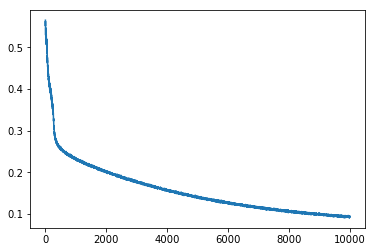

In [18]:
# TODO: print estimated time remaining
for i in range(train_steps):
    pointer = np.random.randint(0, sim_steps/ep_length - batch_size)
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]
    
    batch_x[:,-1] *= np.random.choice(a=[0.0, 1.0], size=(len(batch_x[:,-1])),
                                      p=[zero_speed_probability, 1-zero_speed_probability])
    
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,len(x_components)]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.noise_stddev: [noise_stddev] }
    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 100 == 0 and i != 0:
        print("Loss: {} -- {}".format(loss, i//100))
    losses.append(loss)
plt.plot(losses)

In [19]:
#learning_rate *= .5
#print(learning_rate)
#train_steps = 4000

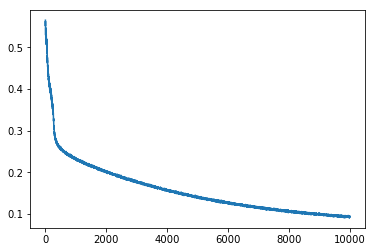

In [20]:
plt.plot(losses)

### Save Network Weights

In [21]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver.save(sess, model_path + '/model.cptk')

'data/rat_square/trial_5/model/model.cptk'

## Load Network Weights

In [22]:
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt == None:
  print('The model {0} could not be found. Make sure you specified the right '
    '--run-path'.format(model_path))
saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from data/rat_square/trial_5/model/model.cptk


INFO:tensorflow:Restoring parameters from data/rat_square/trial_5/model/model.cptk


### Compare Trajectories

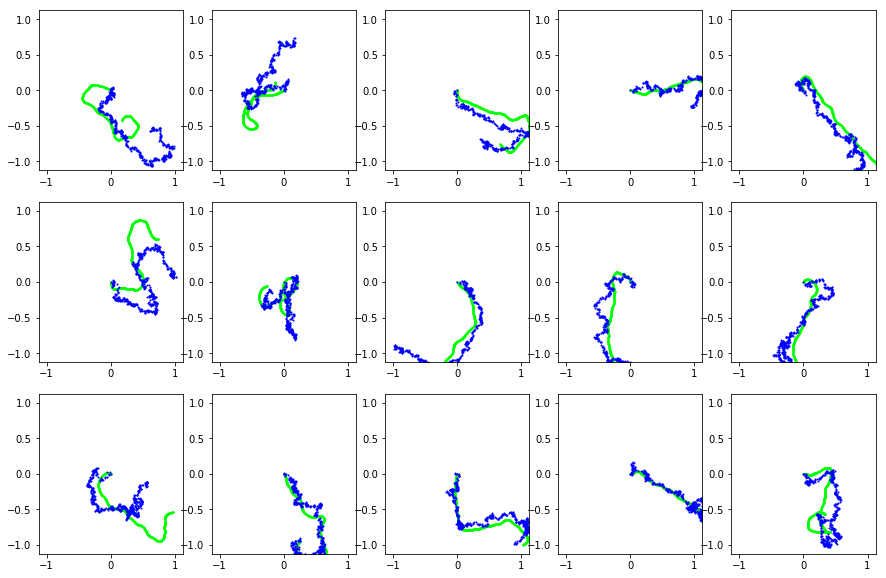

In [23]:
plt.figure(figsize=(15,10))
for i in range(1):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]

    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,len(x_components)]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.noise_stddev: [1*noise_stddev]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict) + batch_y[0]
    
for i in range(min(15, batch_size)):
    # Real - Green | Predicted - Blue
    plt.subplot(3, 5, 1 + i)
    a = i*ep_length
    b = a+ep_length
    plt.scatter(batch_y[a:b,0], batch_y[a:b, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[a:b, 0], yp[a:b, 1], s=1, c=[0,0,1,1])
    plt.ylim(-maze_extents, maze_extents)
    plt.xlim(-maze_extents, maze_extents)
plt.show()

### Display neuron activation rates

In [24]:
resolution = 32
rate = np.zeros([hidden_units, resolution, resolution])
count = np.zeros([resolution, resolution])
for i in range(len(input_x)//(ep_length*batch_size)):
    pointer = i
    batch_x = input_x[pointer*ep_length*batch_size:(pointer+1)*ep_length*batch_size]
    batch_y = input_y[pointer*ep_length*batch_size:(pointer+1)*ep_length*batch_size]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,len(x_components)]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.noise_stddev: [0*noise_stddev]}
    act = sess.run(rat_rnn.output, feed_dict=feed_dict)
    
    for j in range(ep_length*batch_size):
        x = (batch_y[j][0] + maze_extents)/(maze_extents*2) * resolution
        y = (batch_y[j][1] + maze_extents)/(maze_extents*2) * resolution
        count[int(x), int(y)] += 1
        rate[:, int(x), int(y)] += np.abs(act[j, :])
                      
for x in range(resolution):
    for y in range(resolution):
        if count[x, y] > 0:
            rate[:, x, y] /= count[x, y]

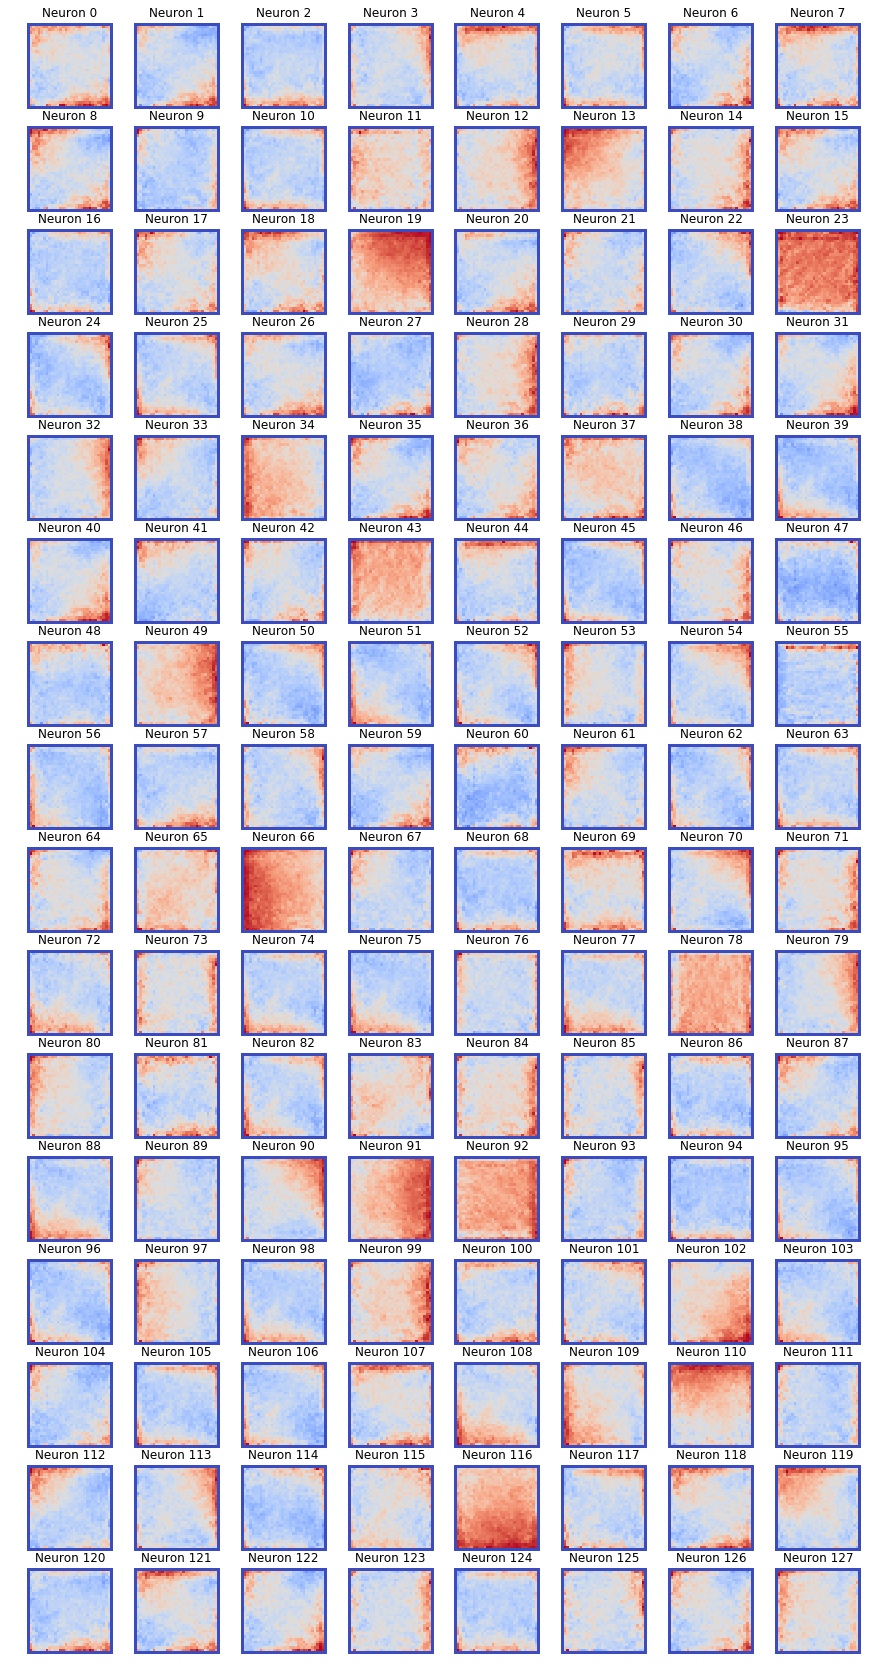

In [25]:
            
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="coolwarm")
    plt.axis('off')
    
plt.show()

## Close TensorFlow Session & Environment

In [26]:
sess.close()
env.close()

NameError: name 'env' is not defined

In [ ]:
print(input_Y)
print(input_y)

## Testing

### RNN prediction
Is prediction computed from the cell state before ($x$) or after ($u$) activation? The original paper uses $u$.

From the output below, it appears the RNN model in this notebook uses $x$, which needs to be corrected.

In [59]:
tf.reset_default_graph()
rat_rnn = RatRNN(len(x_components), 2, 3, 1, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()
init = tf.global_variables_initializer()
sess.run(init)

In [69]:
var = []
for v in tf.trainable_variables():
    print(v.name)
    var.append(sess.run(v))
    print(sess.run(v))

rnn/my_ctrnn_cell/kernel:0
[[ 0.05228174 -0.8318847  -0.7866112 ]
 [-0.35353512 -0.65348524 -0.70358324]
 [ 0.6234941   0.08775604  0.6997573 ]
 [ 0.79532117 -0.11444044  0.42207664]
 [ 0.2628488  -0.8081044   0.07111877]]
rnn/my_ctrnn_cell/bias:0
[0. 0. 0.]
dense/kernel:0
[[1. 1.]
 [1. 1.]
 [1. 1.]]
dense/bias:0
[0. 0.]


In [79]:
x_t = np.array([[1.0, 1.0], [1.0, 1.0]])
feed_dict = {rat_rnn.x: x_t, rat_rnn.train_length: [2], rat_rnn.noise_stddev: [0.0]}
print('output')
out = sess.run(rat_rnn.output, feed_dict=feed_dict)
print(out)
print('y')
#feed_dict = {rat_rnn.output: out, rat_rnn.train_length: [1]}
print(sess.run(rat_rnn.y_pred, feed_dict=feed_dict))


output
[[-0.03012534 -0.148537   -0.14901945]
 [-0.07473143 -0.2688431  -0.29252008]]
y
[[-0.32768178 -0.32768178]
 [-0.6360946  -0.6360946 ]]


In [95]:
# Initial state
x_0 = np.zeros([1,3])
u_0 = np.tanh(x_0) # also all zeros

# t 0-->1
dxdt_0 = np.hstack([[[1.0, 1.0]], u_0]) @ var[0]
dxdt_0 -= x_0
print(dxdt_0)
x_1 = x_0 + tau/10*dxdt_0
print(x_1)
u_1 = np.tanh(x_1)
print(u_1)
y_1 = x_1 @ var[2]
print(y_1)
y_1_ = u_1 @ var[2]
print(y_1_)

[[-0.30125338 -1.48536992 -1.49019444]]
[[-0.03012534 -0.14853699 -0.14901944]]
[[-0.03011623 -0.14745415 -0.14792607]]
[[-0.32768177 -0.32768177]]
[[-0.32549645 -0.32549645]]


In [96]:
# t: 1-->2
dxdt_1 = np.hstack([[[1.0, 1.0]], u_1]) @ var[0]
dxdt_1 -= x_1
print(dxdt_1)
x_2 = x_1 + tau/10*dxdt_1
print(x_2)
y_2 = x_2 @ var[2]
print(y_2)
y_2_ = u_2 @ var[2]
print(y_2_)

[[-0.44606092 -1.20306138 -1.43500632]]
[[-0.07473143 -0.26884313 -0.29252008]]
[[-0.63609464 -0.63609464]]
[[-0.013498 -0.013498]]
